# PEC representation of Rigetti gates using Mitiq
This was originally intended to be a part of the `process_gst.ipynb` notebook, but it seems as though Mitiq and pyGSTi rely on competing versions of Numpy. To fix this conflict, the superoperator restuls of the GST are pickled and then re-imported here.

The Mitiq noisy basis was found by composing operators from the set together. Then, the `mitiq.pec.representations.optimal.find_optimal_representation` method generates an optimal representation of the nosiy gate. The complexity of the distribution and the overhead for different gate depths are compared.

There are several places for further improvement. pyGSTi uses pre-computed lists of feducials, which are required to be informationally complete and maximally orthogonal, and a set of germs to be repeated at different depths, which they term 'amplificationally complete'. The modelpack used by default did not include an idle gate. In the future it would be useful to see how much the inclusion of the idle gate affects the QPD representation. In addition, it would be interesting to test how much the QPD representations differ for different qubits. 

Lastly, a technical issue still remains to be resolved, which is the interpretation $RX(\theta)$ as $\exp(i\frac{\theta}{2})$ or $\exp(-i\frac{\theta}{2})$. It is currently unclear whether this is coming from the mitiq, pyGSTi, pyQuil, or Qiskit representation. Because the superoperator terms are fairly close to their ideal values, it is easy to address the error by simply changing the sign where necessary.

In [2]:
'''
-    NoisyOperations store ideal representation as a generalized PROGRAM object (here using qiskit circuits)
         along with a SuperOperator matrix representing the error channel.
-    NoisyBasis stores a list of NoisyOperations and provides several sampling tools
     find_optimal_representation is a routine that automatically finds a QPD representation of the ideal gate 
     with the smallest possible negative overhead.
'''
from mitiq.pec import NoisyOperation, NoisyBasis 
from mitiq.pec.representations.optimal import find_optimal_representation

#Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SuperOp, Kraus, Operator
from qiskit.circuit.library import RXGate, RZGate, XGate, YGate, ZGate, IGate

#Helper libraries
import pickle
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

#make numpy matrices easier to read
np.set_printoptions(precision=3, suppress=True)
plt.style.use("ggplot")

## Import superoperators
The superoperators were found by running a pyGSTi standard gate set tomography using the `smq1Q_XZ` modelpack. These are pickled in `process_gst.ipynb` and imported here.

In [3]:
fname = "experiment_data/XZ.superop"
with open(fname,"rb") as f: #Load pickled data
    superops = pickle.load(f)

#Create a list of ideal gates as labels for the noisy ones
ideal_gates = [RXGate(-np.pi/2), RZGate(-np.pi/2), IGate()]

## Create noisy basis
From the $M$ gates in the gateset, there are $M^n$ gates in the basis with length $n$. The span theoretically will increase with the depths $n$ that are considered in the set. The following cell generates such a spanning set of the permissible operations by listing out all the words from elements in the gate set with a length $n$ for all $n \leq N$. Then it uses these along with the corresponding ideal circuits to construct `NoisyOperation` elements, and combine these into a `NoisyBasis`. It remains to be seen whether a set with more orthogonality will incresae the quality of the representation.

In [4]:
#This method generates all words of a certain length from a set of superoperators, 
#and returns a list of NoisyOperations
def get_gate_sequences(n):
    NoisyOperations = []

    for string in product(zip(superops,ideal_gates), repeat=n): #combine the noisy and ideal ops and iterate through words
        qc = QuantumCircuit(1)
        superop = SuperOp(np.identity(4)) #start at the identity op

        for (noisy_op, ideal_op) in string: #iterate through all the pairs in string
            qc.append(ideal_op,[0]) #add the ideal op to circuit
            superop = superop.compose(noisy_op) #compose the noisy op for total channel

        NoisyOperations.append(NoisyOperation(qc, superop.data)) #Instatiate NoisyOperation and add to array
    
    return NoisyOperations.copy()

NoisyOperations = []
N = 3

for i in range(N): #do this for all n <= N
    NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))

#combine into basis object
noisy_basis = NoisyBasis(*NoisyOperations)

## Generate PEC representation
If the spanning set is big enough, there may be many combinations of gates that form a QPD representation of the ideal gate within the desired tolerance level. Thus, the challenge is to find the representation
$$
\mathcal{U}_{ideal} = \sum_{\alpha}\eta_\alpha \mathcal{O}_\alpha
$$
Where $\mathcal{O}_\alpha$ are noisy operations and
$$
\gamma = \sum_{\alpha}\vert \eta_\alpha \vert
$$
is minimized. Mitiq provides a method to do this automatically. The `find_optimal_representation` method returns an optimal representation of a `PROGRAM` object, which can be a Circ, Quil, or Qiskit circuit object, given a noisy basis, and a desired tolerance level. In practice, I found that the overhead is highly sensitive to the tolerance level. A nearly perfect representation is accessible, but with an intractible overhead.

As is expected, the noisy gate $RX(-\frac{\pi}{2})$ has the largest coefficient because it closely approximates the true gate, with other corrective terms.

In [11]:
#Optimal circuit to represent
optimal_circuit = QuantumCircuit(1)
optimal_circuit.append(RXGate(-np.pi/2), [0])

#get optimal representation in terms of noisy gates
optimal_rep = find_optimal_representation(optimal_circuit, noisy_basis, tol=.01)
print(optimal_rep)
print("Overhead: ", optimal_rep.norm) #hopefully close to 1

q_0: ───Rx(-0.5π)─── = -0.012*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───Rz(-0.5π)───)-0.017*(q_0: ───Rz(-0.5π)───Rz(-0.5π)───Rz(-0.5π)───)+0.038*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───)-0.003*(q_0: ───Rz(-0.5π)───Rz(-0.5π)───Rx(-0.5π)───)-0.002*(q_0: ───Rx(-0.5π)───Rx(-0.5π)───Rx(-0.5π)───)+0.001*(q_0: ───Rz(-0.5π)───)+0.022*(q_0: ───Rz(-0.5π)───Rx(-0.5π)───)+0.016*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───Rx(-0.5π)───)-0.002*(q_0: ───Rz(-0.5π)───Rx(-0.5π)───Rx(-0.5π)───)+0.973*(q_0: ───Rx(-0.5π)───)
Overhead:  1.085540377824781


The approximated superoperator is very close to the desired gate

In [6]:
matrices = [m.channel_matrix for m in optimal_rep.noisy_operations]
mat = sum(m*coeff for (m,coeff) in zip(matrices, optimal_rep.coeffs))
print("Approximated superoperator")
print(mat)
print('------------------------------')
print("Ideal superoperator")
ideal_mat = SuperOp(RXGate(np.pi/2)).data #It clearly matches RX(pi/2), but I don't know why
print(ideal_mat)

Approximated superoperator
[[ 0.504-0.j    -0.01 -0.49j  -0.01 +0.49j   0.504-0.j   ]
 [-0.003-0.494j  0.49 -0.01j   0.49 +0.01j   0.01 +0.49j ]
 [-0.003+0.494j  0.49 -0.01j   0.49 +0.01j   0.01 -0.49j ]
 [ 0.51 +0.j     0.01 +0.49j   0.01 -0.49j   0.51 -0.j   ]]
------------------------------
Ideal superoperator
[[0.5+0.j  0. -0.5j 0. +0.5j 0.5+0.j ]
 [0. -0.5j 0.5+0.j  0.5+0.j  0. +0.5j]
 [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
 [0.5+0.j  0. +0.5j 0. -0.5j 0.5+0.j ]]


## Testing effects of different parameters
The relevant independent parameters are the max depth $N$ of the noisy basis and the tolerance of the fit. These might effect the final estimate in two ways: the overhead can get larger or closer to one, and the probability distribution may become more or less complicated to sample.

In [36]:
#generate basis of circuits with depth N and below
def generate_noisy_basis(N):
    NoisyOperations = []
    for i in range(N): #do this for all n <= N
        NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))
    #combine into basis object
    return NoisyBasis(*NoisyOperations)

#frobenius distance between two matrices
def frobenius_dist(op1, op2):
    mat = op1-op2
    return (np.sqrt(np.trace(np.dot(mat,np.conjugate(np.transpose(mat)))))).real

In [53]:
#lengths of these sets become large
max_depths = [5] #Procedure fails for 2<=N<=6
noisy_bases = [generate_noisy_basis(N) for N in max_depths]

These next two cells compare the complexity of the distribution, the sampling overhead, and the distance to the ideal matrix. When looking at the complexity of the resulting probability distribution, the coefficients less than $1\times 10^{-7}$ were excluded because they were assumed to be to small to randomly sample.

In [56]:
optimal_reps = [find_optimal_representation(optimal_circuit, noisy_basis_N, tol=1e-5) for noisy_basis_N in noisy_bases] #fails for 2<=N<=5
print("Tolerance 1e-5:")
for optimal_rep in optimal_reps:
    channel_ops = [op.channel_matrix for op in optimal_rep.noisy_operations]
    channel = sum(op*coeff for (op,coeff) in zip(channel_ops, optimal_rep.coeffs))
    print("QPD with",
                    len([coeff for coeff in optimal_rep.coeffs if coeff > 1e-7]),
                    "operators and overhead",
                    optimal_rep.norm,
                    "and distance to ideal matrix",
                    frobenius_dist(channel, ideal_mat))

Tolerance 1e-5:
QPD with 34 operators and overhead 1.7338230851671923 and distance to ideal matrix 4.957837202478995e-05


In [585]:
optimal_reps = [find_optimal_representation(optimal_circuit, noisy_basis_N, tol=.01) for noisy_basis_N in noisy_bases] #fails for 2<=N<=5
print("Tolerance .01:")
for optimal_rep in optimal_reps:
    channel_ops = [op.channel_matrix for op in optimal_rep.noisy_operations]
    channel = sum(op*coeff for (op,coeff) in zip(channel_ops, optimal_rep.coeffs))
    print("QPD with",
                    len([coeff for coeff in optimal_rep.coeffs if coeff > 1e-7]),
                    "operators and overhead",
                    optimal_rep.norm,
                    "and distance to ideal matrix",
                    frobenius_dist(channel, ideal_mat))

Tolerance .01:
QPD with 7 operators and overhead 1.0339647618960912 and distance to ideal matrix 0.0434106268407838
QPD with 16 operators and overhead 1.0580912023823537 and distance to ideal matrix 0.046535634799173754
QPD with 29 operators and overhead 1.0564030091714847 and distance to ideal matrix 0.04482870178549561


## Overhead advantage for noise scaling
The following cells show the overhead advantage achieved through noise scaling with an overhead of $\gamma = 1.73$, obtained through the $10^{-5}$ tolerance fit. A hypothetical circuit of depth eight is used for reference.

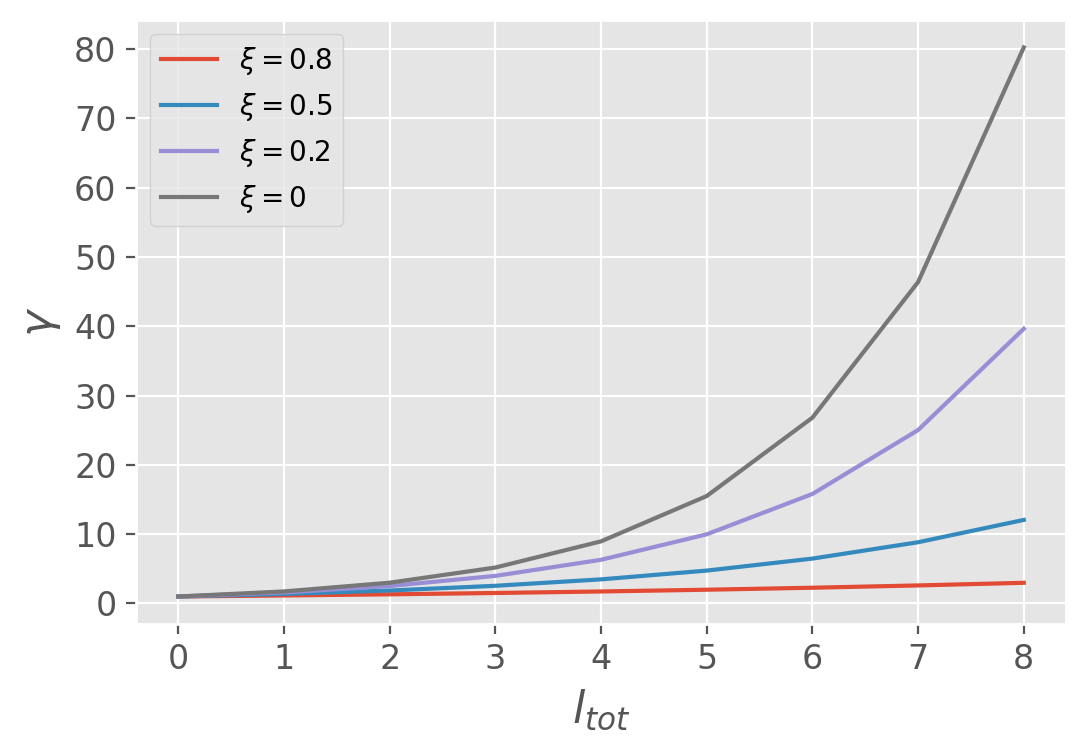

In [8]:
ax = np.arange(9)
plt.figure(figsize=(6,4), dpi = 200)
gamma = 1.73
lmbdas = [.8,.5,.2,0]
for lmbda in lmbdas:
    plt.plot(ax, [(gamma-lmbda*(gamma-1))**n for n in ax])

plt.xlabel(r"$l_{tot}$", fontsize = 16)
plt.ylabel(r"$\gamma$", fontsize = 16)
plt.tick_params(axis= "both", labelsize = 12)
plt.legend([r"$\xi = $" + str(lmbda) for lmbda in lmbdas])

Text(0, 0.5, 'Overhead')

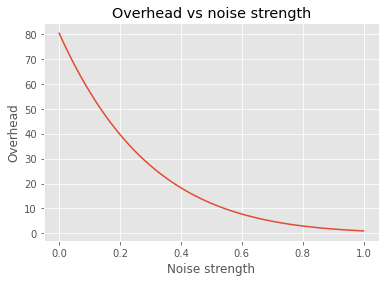

In [7]:
xax = np.linspace(0,1, 100)
plt.plot(xax, [(gamma-lmbda*(gamma-1))**8 for lmbda in xax])
plt.title("Overhead vs noise strength")
plt.xlabel("Noise strength")
plt.ylabel("Overhead")